<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/J-TKim/Gans_in_action/blob/master/Ch7/Ch7_SGAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 코드 7-1 모듈 임포트
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import backend as K

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import (Activation, BatchNormalization, Concatenate,
                                    Dense, Dropout, Flatten, Input, Lambda, Reshape)
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
# 코드 7-2 모델 입력 차원
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # 입력 이미지 차원

z_dim = 100 # 생성자의 입력으로 사용할 잡음 벡터의 크기

num_classes = 10 # 데이터셋에 있는 클래스 개수

In [3]:
# 코드 7-3 훈련 데이트셋과 테스트의 데이터셋
class Dataset:
    def __init__(self, num_labeled):
        
        self.num_labeled = num_labeled # 훈련에 사용할 레이블된 샘플 개수 
        
        # MNIST 데이터셋 적재
        (self.x_train, self.y_train), (self.x_test, self.y_test) = mnist.load_data()
        
        def preprocess_imgs(x):
            x = (x.astype(np.float32) - 127.5) / 127.5
            x = np.expand_dims(x, axis=3)
            return x
        
        def preprocess_labels(y):
            return y.reshape(-1, 1)
        
        # 훈련 데이터
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)
        
        # 테스트 데이터
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)
        
    def batch_labeled(self, batch_size):
        # 레이블된 이미지와 레이블된 랜덤 배치 만들기
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels
    
    def batch_unlabeled(self, batch_size):
        # 레이블이 없는 이미지의 랜덤 배치 만들기
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                               batch_size)
        imgs = self.x_train[idx]
        return imgs
    
    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train
    
    def test_set(self):
        return self.x_test, self.y_test

In [4]:
# 사용할 레이블된 샘플 개수(나머지는 레이블 없이 사용합니다)
num_labeled = 100

dataset = Dataset(num_labeled)

In [5]:
# 코드 7-4 SGAN 생성자
def build_generator(z_dim):
    
    model = Sequential()
    
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    # 완결 연결 층을 사용해 입력을 7 x 7 x 256 크기 텐서로 바꿉니다.
    model.add(Reshape((7, 7, 256)))
    
    # 7 x 7 x 256 에서 14 x 14 x 128 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding="same"))
    
    # 배치 정규화
    model.add(BatchNormalization())
    
    # LeakyReLU 활성화 함수
    model.add(LeakyReLU(alpha=0.01))
    
    # 14 x 14 x 128에서 14 x 14 x 64 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding="same"))
    
    model.add(BatchNormalization())
    
    model.add(LeakyReLU(alpha=0.01))
    
    # 14 x 14 x 64 에서 28 x 28 x 1 텐서로 바꾸는 전치 합성곱 층
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding="same"))
    
    # tanh 활성화 함수
    model.add(Activation("tanh"))
    
    return model

In [6]:
# 코드 7-5 SGAN 판별자
def build_discriminator_net(img_shape):
    
    model = Sequential()
    
    # 28 x 28 x 1 에서 14 x 14 x 32 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(32,
              kernel_size=3,
              strides=2,
              input_shape=img_shape,
              padding="same"))
    
    model.add(LeakyReLU(alpha=0.01))
    
    # 14 x 14 x 32 에서 7 x 7 x 64 텐서로 바꾸는 합성곱 층
    model.add(
        Conv2D(64,
              kernel_size=3,
              strides=2,
              input_shape=img_shape,
              padding="same"))
    
    model.add(LeakyReLU(alpha=0.01))
    
    model.add(
        Conv2D(128,
              kernel_size=3,
              strides=2,
              input_shape=img_shape,
              padding="same"))
    
    model.add(LeakyReLU(alpha=0.01))
    
    # 드롭아웃
    model.add(Dropout(0.5))
    
    # 텐서 펼치기
    model.add(Flatten())
    
    # num_classes개의 뉴런을 가진 완전 연결 층
    model.add(Dense(num_classes))
    
    return model

In [7]:
# 코드, 7-6 SGAN 판별자: 지도 학습 모델
def build_discriminator_supervised(discriminator_net):
    
    model = Sequential()
    
    model.add(discriminator_net)
    
    # 진짜 클래스에 대한 예측 확률을 출력하는 소프트맥스 활성화 함수
    model.add(Activation("softmax"))
    
    return model

In [8]:
# 코드 7-7 SGAN 판별자: 비지도 학습 모델
def build_discriminator_unsupervised(discriminator_net):
    
    model = Sequential()
    
    model.add(discriminator_net)
    
    def predict(x):
        # 진짜 클래스에 대한 확률 분포를 진짜 대 가짜의 이진 확률로 변환합니다.
        prediction = 1.0 - (1.0 /
                           (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        
        return prediction
        
    # 앞서 정의한 진짜 대 가짜 확률을 출력하는 뉴런
    model.add(Lambda(predict))
        
    return model

In [9]:
# 코드 7-8 GAN 모델 구성
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    model.add(generator) # 생성자와 판별자 모델을 연결하기
    model.add(discriminator)
    
    return model

In [10]:
# 판별자 기반 모델: 이 층들은 지도 학습 훈련과 비지도 학습 훈련에 공유됩니다.
discriminator_net = build_discriminator_net(img_shape)

# 지도 학습 훈련을 위해 판별자를 만들고 컴파일합니다.
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss = "categorical_crossentropy",
                                 metrics=["accuracy"],
                                 optimizer=Adam(learning_rate=0.0003))

# 비지도 학습 훈련을 위해 판별자를 만들고 컴파일합니다.
discriminator_unsupervised = build_discriminator_unsupervised(
                                discriminator_net)
discriminator_unsupervised.compile(loss="binary_crossentropy",
                                  optimizer=Adam())

# 생성자를 만듭니다.
generator = build_generator(z_dim)

# 생성자 훈련을 위해 판별자의 모델 파라미터를 동결합니다.
discriminator_unsupervised.trainable = False

# 생성자를 훈련하기 위해 고정된 판별자로 GAN 모델을 만들고 컴파일합니다. 참고: 비지도 학습용 판별자를 사용하세요
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss="binary_crossentropy", optimizer=Adam())

In [11]:
# 코드 7-9 SGAN 훈련 알고리즘
supervised_losses = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    
    # 진짜 이미지의 레이블: 모두 1
    real = np.ones((batch_size, 1))
    
    # 가짜 이미지의 레이블: 모두 0
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        # 레이블된 샘플을 가져옵니다.
        imgs, labels = dataset.batch_labeled(batch_size)
        
        # 레이블을 원-핫 인코딩합니다.
        labels = to_categorical(labels, num_classes=num_classes)
        
        # 레이블이 없는 샘플을 가져옵니다.
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)
        
        # 가짜 이미지의 배치를 생성합니다
        z = np.random.normal(0, 1, (batch_size, z_dim))
        
        gen_imgs = generator.predict(z)
        
        # 레이블된 진짜 샘플에서 훈련합니다.
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)
        
        # 레이블이 없는 진짜 샘플에서 훈련합니다.
        d_loss_real = discriminator_unsupervised.train_on_batch(imgs_unlabeled, real)
        
        # 가짜 샘플에서 훈련합니다.
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)
        
        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # 가짜 이미지의 배치를 생성합니다.
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)
        
        # 생성자를 훈련합니다.
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))
        
        if (iteration + 1) % sample_interval == 0:
            
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)
            
            print(
                "%d [D 손실: %.4f, 정확도: %.2f%%] [D 손실: %.4f] [G 손실: %f]" %
                (iteration + 1, d_loss_supervised, 100 * accuracy,
                d_loss_unsupervised, g_loss))

In [12]:
# 코드 7-10 모델 훈련
iterations = 8000
batch_size = 32
sample_interval = 800

train(iterations, batch_size, sample_interval)

800 [D 손실: nan, 정확도: 15.62%] [D 손실: 7.6246] [G 손실: 0.000000]
1600 [D 손실: nan, 정확도: 18.75%] [D 손실: 7.6246] [G 손실: 0.000000]
2400 [D 손실: nan, 정확도: 12.50%] [D 손실: 7.6246] [G 손실: 0.000000]
3200 [D 손실: nan, 정확도: 15.62%] [D 손실: 7.6246] [G 손실: 0.000000]
4000 [D 손실: nan, 정확도: 9.38%] [D 손실: 7.6246] [G 손실: 0.000000]
4800 [D 손실: nan, 정확도: 15.62%] [D 손실: 7.6246] [G 손실: 0.000000]
5600 [D 손실: nan, 정확도: 15.62%] [D 손실: 7.6246] [G 손실: 0.000000]
6400 [D 손실: nan, 정확도: 9.38%] [D 손실: 7.6246] [G 손실: 0.000000]
7200 [D 손실: nan, 정확도: 9.38%] [D 손실: 7.6246] [G 손실: 0.000000]
8000 [D 손실: nan, 정확도: 6.25%] [D 손실: 7.6246] [G 손실: 0.000000]


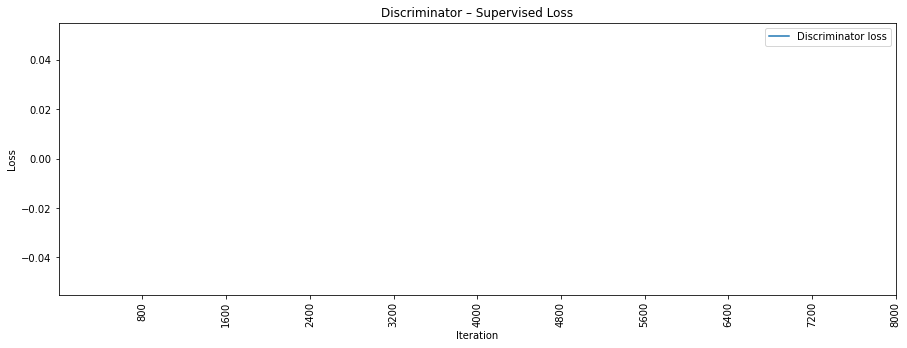

In [13]:
losses = np.array(supervised_losses)

# 판별자의 지도 학습 손실을 그립니다.
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

100/100 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.1300
Training Accuracy: 13.00%


In [15]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에서 분류 정확도 계산
_, accuracy = discriminator_supervised.evaluate(x, y)
print("테스트 정확도:%.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 85us/sample - loss: nan - accuracy: 0.09800s - loss: nan - ac
테스트 정확도:9.80%


In [16]:
# 코드 7-12 완전한 지도 학습으로 훈련한 분류기
# SGAN 판별자와 같은 네트워크 구조를 가진 지도 학습 분류기
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))

mnist_classifier.compile(loss = "categorical_crossentropy",
                        metrics=["accuracy"],
                        optimizer=Adam())

In [17]:
imgs, labels = dataset.training_set()

# 레이블을 원-핫 인코딩합니다.
labels = to_categorical(labels, num_classes=num_classes)

# 분류기를 훈련합니다.
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Train on 100 samples
Epoch 1/30
100/100 [==============================] - 1s 6ms/sample - loss: 2.2988 - accuracy: 0.0900
Epoch 2/30
100/100 [==============================] - 0s 173us/sample - loss: 2.2106 - accuracy: 0.3300
Epoch 3/30
100/100 [==============================] - 0s 160us/sample - loss: 2.1294 - accuracy: 0.3900
Epoch 4/30
100/100 [==============================] - 0s 176us/sample - loss: 2.0385 - accuracy: 0.3400
Epoch 5/30
100/100 [==============================] - 0s 164us/sample - loss: 1.8954 - accuracy: 0.3500
Epoch 6/30
100/100 [==============================] - 0s 186us/sample - loss: 1.6769 - accuracy: 0.5700
Epoch 7/30
100/100 [==============================] - 0s 184us/sample - loss: 1.4919 - accuracy: 0.6700
Epoch 8/30
100/100 [==============================] - 0s 197us/sample - loss: 1.1633 - accuracy: 0.7300
Epoch 9/30
100/100 [==============================] - 0s 179us/sample - loss: 0.9846 - accuracy: 0.7600
Epoch 10/30
100/100 [========================

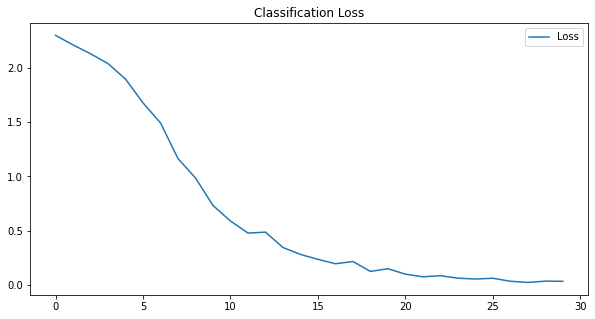

In [18]:
# 분류 손실을 그립니다
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()
plt.show()

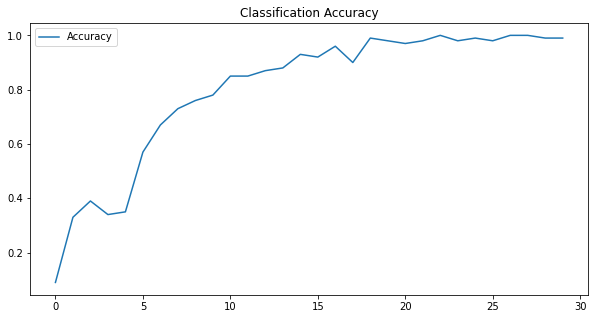

In [19]:
# 분류 정확도를 그립니다.
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy")
plt.legend()
plt.show()

In [20]:
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# 훈련 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

100/100 [==============================] - 0s 1ms/sample - loss: 0.0112 - accuracy: 1.0000
Training Accuracy: 100.00%


In [21]:
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# 테스트 세트에 대한 분류 정확도를 계산합니다.
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

10000/10000 [==============================] - 1s 81us/sample - loss: 1.4163 - accuracy: 0.6890
Test Accuracy: 68.90%
